In [1]:
# Import necessary libraries
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from datetime import datetime
import cmocean.cm as cmo

# Set plotting style for scientific publication
plt.style.use('default')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## Load and Explore Data

This section imports the Bocquet et al., (2024) sea ice thickness (SIT) dataset and performs initial data exploration. The dataset provides monthly Antarctic sea-ice thickness measurements from CryoSat-2 satellite observations, presented in a structured NetCDF format. We explore the dataset structure, variables, and associated metadata to establish a foundation for subsequent analyses.

In [2]:
# Set file path
data_dir = r"D:\phd\data\Bocquet_2024_cs2"
file_path = os.path.join(data_dir, "SIT_sh_c2esaD1_202101_202112.nc")

# Load the dataset
ds = xr.open_dataset(file_path)

# Print basic information about the dataset
print("Dataset Information:")
print(ds)
print("\nVariables in the dataset:")
for var_name, var in ds.variables.items():
    print(f"{var_name}: {var.attrs.get('long_name', 'No long name')} - {var.attrs.get('units', 'No units')}")

Dataset Information:
<xarray.Dataset> Size: 1GB
Dimensions:                        (time: 12, y: 712, x: 712)
Coordinates:
    lat                            (y, x) float32 2MB ...
    lon                            (y, x) float32 2MB ...
  * time                           (time) datetime64[ns] 96B 2021-01-15 ... 2...
  * x                              (x) float32 3kB 6.25e+03 ... 8.894e+06
  * y                              (y) float32 3kB 8.894e+06 ... 6.25e+03
Data variables: (12/55)
    sea_ice_freeboard              (time, y, x) float32 24MB ...
    total_freeboard                (time, y, x) float32 24MB ...
    sea_ice_thickness              (time, y, x) float32 24MB ...
    sea_ice_draft                  (time, y, x) float32 24MB ...
    ice_concentration              (time, y, x) float32 24MB ...
    ice_density                    (time, x, y) float32 24MB ...
    ...                             ...
    STAT_sea_ice_draft_q975        (time, y, x) float32 24MB ...
    STAT_sea_

## Data Analysis and Statistics

Here we conduct preliminary statistical analysis on the Antarctic sea-ice thickness data. We identify key variables, extract temporal information, and calculate essential statistical metrics including monthly and annual means. These statistics provide context for spatial and temporal variability in Antarctic sea-ice thickness throughout 2021, establishing baseline characteristics for subsequent regional analyses.

In [3]:
# Identify the main SIT variable - you may need to adjust this based on actual variable name
# Assuming the variable is named 'sit' or has 'thick' in its name
sit_vars = [var for var in ds.data_vars if 'thick' in var.lower() or 'sit' in var.lower()]
if sit_vars:
    sit_var = sit_vars[0]
    print(f"Using sea ice thickness variable: {sit_var}")
else:
    # Try to identify based on dimensions (likely a 3D variable with time, lat, lon)
    sit_var = [var for var in ds.data_vars 
               if len(ds[var].dims) >= 3 and 'time' in ds[var].dims][0]
    print(f"Using variable {sit_var} as sea ice thickness")

# Get time information
time_values = ds.time.values
first_date = pd.to_datetime(time_values[0])
last_date = pd.to_datetime(time_values[-1])
print(f"Time range: {first_date.strftime('%Y-%m-%d')} to {last_date.strftime('%Y-%m-%d')}")
print(f"Number of time steps: {len(time_values)}")

# Basic statistics
monthly_mean = np.array([ds[sit_var].isel(time=i).mean().values for i in range(len(time_values))])
monthly_max = np.array([ds[sit_var].isel(time=i).max().values for i in range(len(time_values))])
annual_mean = ds[sit_var].mean(dim='time')

print("\nSea Ice Thickness Statistics:")
print(f"Annual mean: {annual_mean.mean().values:.2f} m")
print(f"Maximum monthly mean: {np.max(monthly_mean):.2f} m (Month: {np.argmax(monthly_mean)+1})")
print(f"Minimum monthly mean: {np.min(monthly_mean):.2f} m (Month: {np.argmin(monthly_mean)+1})")

Using sea ice thickness variable: sea_ice_thickness
Time range: 2021-01-15 to 2021-12-15
Number of time steps: 12

Sea Ice Thickness Statistics:
Annual mean: 1.02 m
Maximum monthly mean: 1.96 m (Month: 2)
Minimum monthly mean: 0.96 m (Month: 11)


## Visualisation Functions

This section defines custom functions for scientific visualisation of Antarctic sea-ice data. The *plot_polar_map()* function creates standardised polar stereographic projections with appropriate cartographic elements and consistent visual parameters, ensuring scientific rigor in spatial representations. These functions enable consistent and reproducible visualisations across the analysis.

In [11]:
def plot_polar_map(data, title, cmap='viridis', vmin=None, vmax=None, cbar_label='', time_str=''):
    """Create a polar stereographic map of Antarctic data."""
    fig = plt.figure(figsize=(5, 4))
    
    # Use South Polar Stereographic projection
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    
    # Set the extent to focus on Antarctica and surrounding Southern Ocean
    ax.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
    
    # Add coastlines and gridlines
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    
    # Plot the data
    if vmin is None:
        vmin = np.nanpercentile(data, 5)
    if vmax is None:
        vmax = np.nanpercentile(data, 95)
    
    mesh = ax.pcolormesh(data.lon, data.lat, data, 
                        transform=ccrs.PlateCarree(),
                        cmap=cmap, vmin=vmin, vmax=vmax)
    
    # Add colorbar
    cbar = plt.colorbar(mesh, ax=ax, orientation='horizontal', pad=0.05, fraction=0.05)
    cbar.set_label(cbar_label)
    
    # Add title with time information
    plt.title(f"{title}\n{time_str}")
    
    return fig, ax

## Monthly Sea-Ice Thickness Maps

We visualise the seasonal evolution of Antarctic sea-ice thickness through a comparative analysis of three key months in 2021: January (summer minimum), July (winter), and September (maximum extent). This multi-panel visualisation illustrates the pronounced seasonal cycle in sea ice thickness, revealing spatial patterns of accumulation and ablation across the Southern Ocean.

C:\Users\xliu38\AppData\Local\Temp\ipykernel_8736\2955308395.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


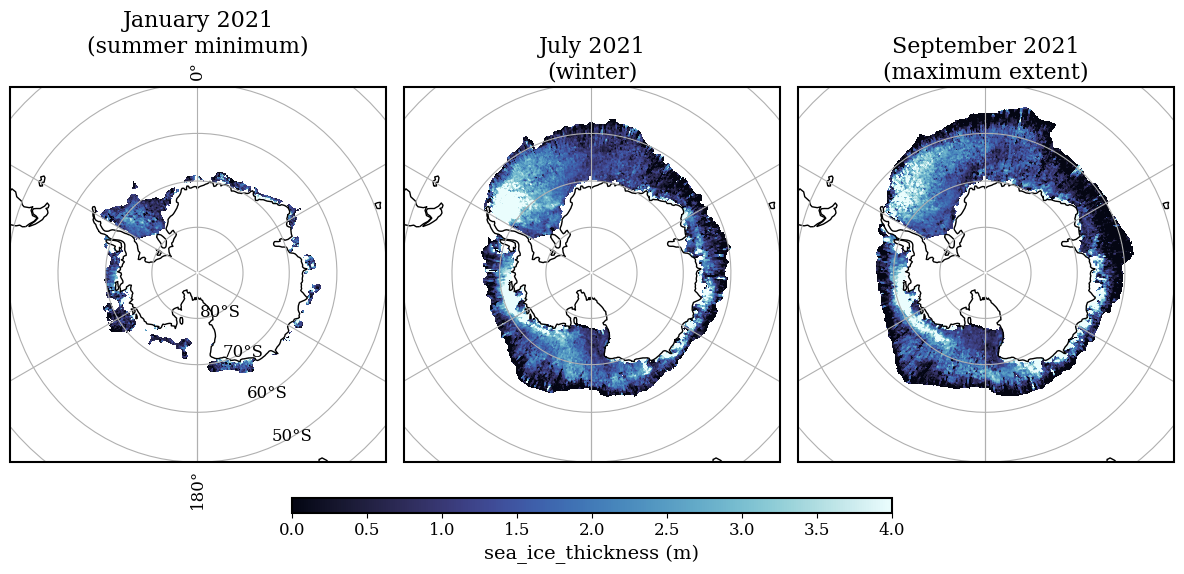

In [13]:
# Create a figure with 1 row and 3 columns for monthly comparisons
fig = plt.figure(figsize=(12, 5))

# Get data for each month
months = [
    (0, "January 2021", "summer minimum"),  # (index, title, description)
    (6, "July 2021", "winter"),
    (8, "September 2021", "maximum extent")
]

# Common parameters
vmin, vmax = 0, 4
cmap = cmo.ice
cbar_label = f"{ds[sit_var].attrs.get('long_name', 'Sea Ice Thickness')} ({ds[sit_var].attrs.get('units', 'm')})"

# Create each subplot
for i, (month_idx, month_name, month_desc) in enumerate(months):
    # Create subplot
    ax = fig.add_subplot(1, 3, i+1, projection=ccrs.SouthPolarStereo())
    
    # Get data for this month
    sit_data = ds[sit_var].isel(time=month_idx)
    date_str = pd.to_datetime(ds.time.values[month_idx]).strftime('%B %Y')
    
    # Set map properties
    ax.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines(draw_labels=True if i == 0 else False)  # Only show labels on first plot
    
    # Plot the data
    mesh = ax.pcolormesh(sit_data.lon, sit_data.lat, sit_data, 
                       transform=ccrs.PlateCarree(),
                       cmap=cmap, vmin=vmin, vmax=vmax)
    
    # Add title
    ax.set_title(f"{month_name}\n({month_desc})")

# Add a common colorbar at the bottom
cbar_ax = fig.add_axes([0.25, 0.06, 0.5, 0.03])  # [left, bottom, width, height]
cbar = fig.colorbar(mesh, cax=cbar_ax, orientation='horizontal')
cbar.set_label(cbar_label)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make space for the colorbar
plt.show()

## Seasonal Cycle Analysis

This section quantifies the seasonal cycle of Antarctic sea-ice thickness through time series analysis. We visualise monthly mean and maximum thickness values throughout 2021, revealing the temporal evolution of sea ice growth and decay. The analysis highlights the characteristic asymmetric pattern of gradual winter growth followed by more rapid summer decline in sea-ice thickness.

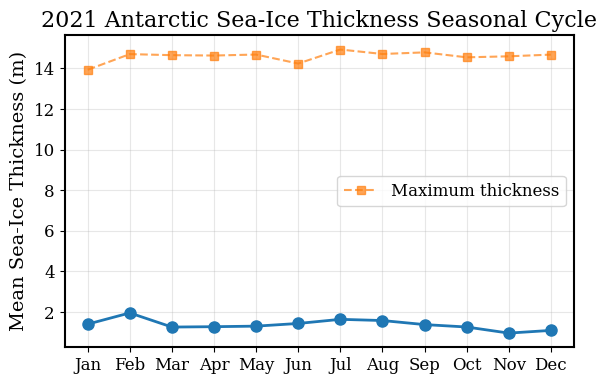

In [14]:
# Create a seasonal cycle plot
fig, ax = plt.subplots(figsize=(6, 4))

month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot monthly mean thickness
ax.plot(range(1, 13), monthly_mean, 'o-', linewidth=2, markersize=8, color='#1f77b4')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_labels)
ax.set_ylabel(f"Mean Sea-Ice Thickness ({ds[sit_var].attrs.get('units', 'm')})")
ax.set_title("2021 Antarctic Sea-Ice Thickness Seasonal Cycle")
ax.grid(True, alpha=0.3)

# Add maximum thickness line
ax.plot(range(1, 13), monthly_max, 's--', linewidth=1.5, markersize=6, color='#ff7f0e',
        alpha=0.7, label='Maximum thickness')
ax.legend()

plt.tight_layout()
plt.show()

## Anomaly Analysis

We examine spatial anomalies in sea-ice thickness to identify regions of positive and negative deviations from annual mean conditions. The analysis focuses on September (maximum extent) anomalies and includes a complementary assessment of latitudinal variations in sea-ice thickness. These analyses reveal the spatial heterogeneity of sea-ice thickness across different Antarctic sectors and latitude bands.

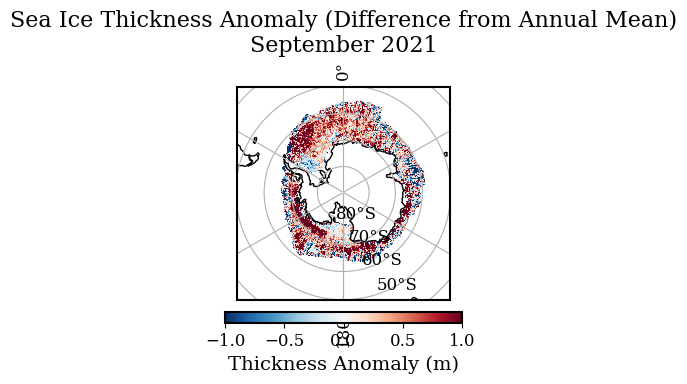

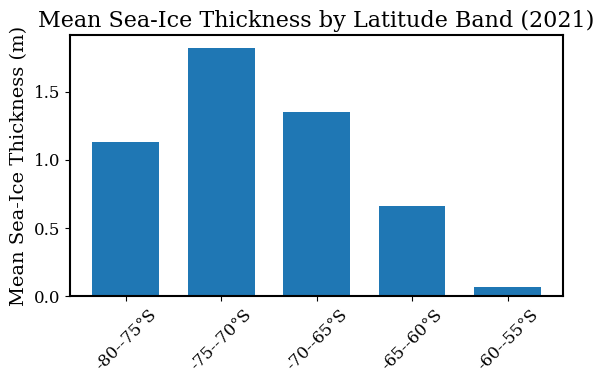

In [15]:
# Calculate anomaly for September (relative to annual mean)
sep_anomaly = sep_sit - annual_mean

fig, ax = plot_polar_map(
    sep_anomaly, 
    f"Sea Ice Thickness Anomaly (Difference from Annual Mean)", 
    cmap='RdBu_r', 
    vmin=-1, 
    vmax=1, 
    cbar_label=f"Thickness Anomaly ({ds[sit_var].attrs.get('units', 'm')})",
    time_str=sep_date
)
plt.tight_layout()
plt.show()

# Calculate zonal mean thickness by latitude
lat_bands = np.arange(-80, -50, 5)
lat_means = []

for i in range(len(lat_bands)-1):
    south_bound = lat_bands[i]
    north_bound = lat_bands[i+1]
    
    # Select data within the latitude band
    band_data = annual_mean.where((annual_mean.lat >= south_bound) & (annual_mean.lat < north_bound))
    mean_val = band_data.mean().values
    lat_means.append(mean_val)

# Plot zonal means
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(range(len(lat_means)), lat_means, width=0.7)
ax.set_xticks(range(len(lat_means)))
ax.set_xticklabels([f"{lat_bands[i]}-{lat_bands[i+1]}°S" for i in range(len(lat_bands)-1)])
ax.set_ylabel(f"Mean Sea-Ice Thickness ({ds[sit_var].attrs.get('units', 'm')})")
ax.set_title("Mean Sea-Ice Thickness by Latitude Band (2021)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Sea Ice Thickness Distribution

This section characterises the statistical distribution of sea-ice thickness during the austral winter (July 2021). The frequency distribution analysis provides insights into the predominant thickness categories and the overall variability of sea-ice thickness. Understanding these distributions is essential for parameterising sea-ice processes in climate models and interpreting satellite observations.

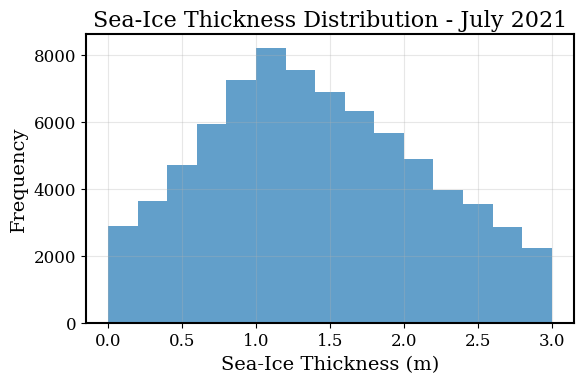

Analysis complete


In [16]:
# Calculate thickness distribution for winter (July)
thickness_bins = np.arange(0, 3.1, 0.2)  # 0 to 3m in 0.2m bins
jul_values = jul_sit.values.flatten()
jul_values = jul_values[~np.isnan(jul_values)]

fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(jul_values, bins=thickness_bins, alpha=0.7, color='#1f77b4')
ax.set_xlabel(f"Sea-Ice Thickness ({ds[sit_var].attrs.get('units', 'm')})")
ax.set_ylabel("Frequency")
ax.set_title(f"Sea-Ice Thickness Distribution - {jul_date}")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Close the dataset
ds.close()

print("Analysis complete")

## Regional Sea Ice Analysis: Weddell and Ross Seas

We now focus on two key sectors of the Southern Ocean: the Weddell Sea (62°W-15°E) and Ross Sea (160°E-140°W). These regions are critical components of the Antarctic cryosphere with distinct sea-ice regimes influenced by different oceanographic and atmospheric conditions. This regional analysis enables direct comparison of sea-ice characteristics between these important Antarctic sectors.

In [17]:
## Regional Analysis: Weddell and Ross Seas

# Define the longitude ranges for Weddell and Ross seas
# Note: For Ross Sea, we need to handle the longitude range that crosses the dateline
ross_lon_range = [(160, 180), (-180, -140)]  # 160°E to 140°W (split across dateline)
weddell_lon_range = [(-62, 15)]  # 62°W to 15°E

def in_region(lon, lat, lon_ranges):
    """
    Check if a point is within the specified longitude ranges
    
    Parameters:
    -----------
    lon : array-like
        Longitude values
    lat : array-like
        Latitude values
    lon_ranges : list of tuples
        List of (min_lon, max_lon) tuples defining the longitude ranges
        
    Returns:
    --------
    mask : array-like
        Boolean mask where True indicates points within the region
    """
    mask = np.zeros_like(lon, dtype=bool)
    for lon_min, lon_max in lon_ranges:
        mask = mask | ((lon >= lon_min) & (lon <= lon_max))
    return mask

# Create regional masks
weddell_mask = in_region(ds.lon, ds.lat, weddell_lon_range)
ross_mask = in_region(ds.lon, ds.lat, ross_lon_range)

# Define function to extract regional data
def extract_regional_data(data_array, region_mask):
    """Extract data for a specific region using a mask."""
    return data_array.where(region_mask)

# Extract data for each region across all time steps
weddell_sit = extract_regional_data(ds[sit_var], weddell_mask)
ross_sit = extract_regional_data(ds[sit_var], ross_mask)

# Calculate monthly statistics for each region
time_range = range(len(time_values))
weddell_monthly_mean = np.array([weddell_sit.isel(time=i).mean().values for i in time_range])
ross_monthly_mean = np.array([ross_sit.isel(time=i).mean().values for i in time_range])

weddell_monthly_max = np.array([weddell_sit.isel(time=i).max().values for i in time_range])
ross_monthly_max = np.array([ross_sit.isel(time=i).max().values for i in time_range])

print("\nRegional Statistics:")
print(f"Weddell Sea - Annual mean: {np.mean(weddell_monthly_mean):.2f} m")
print(f"Ross Sea - Annual mean: {np.mean(ross_monthly_mean):.2f} m")


Regional Statistics:
Weddell Sea - Annual mean: 1.53 m
Ross Sea - Annual mean: 1.11 m


### Visualising Regional Sea-Ice Thickness

This section presents a comparative spatial analysis of sea-ice thickness in the Weddell and Ross seas during September 2021 (maximum extent). We visualise the distinct spatial patterns in each sector and examine their seasonal evolution through comparative time-series analysis. The visualisation highlights regional differences in sea-ice thickness magnitude and spatiotemporal variability.

C:\Users\xliu38\AppData\Local\Temp\ipykernel_8736\702155941.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


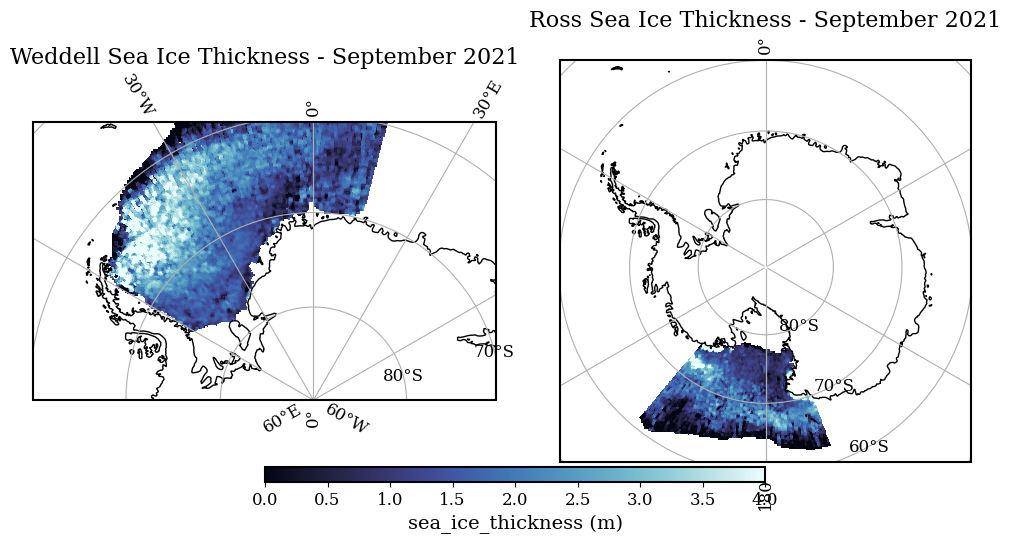

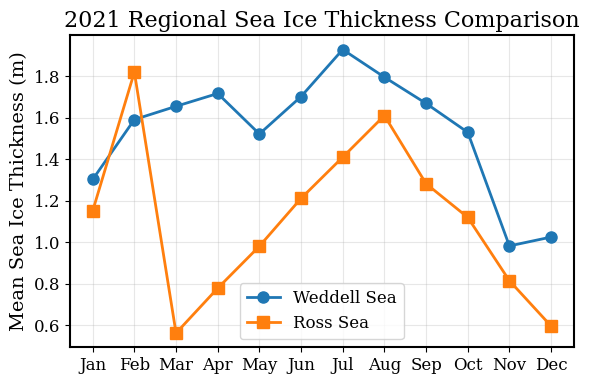

In [23]:
# Create comparison maps for both seas for a specific month (September - maximum extent)
fig = plt.figure(figsize=(10, 5))

# Common parameters
vmin, vmax = 0, 4
cmap = cmo.ice
cbar_label = f"{ds[sit_var].attrs.get('long_name', 'Sea Ice Thickness')} ({ds[sit_var].attrs.get('units', 'm')})"
month_idx = 8  # September (maximum extent)
date_str = pd.to_datetime(ds.time.values[month_idx]).strftime('%B %Y')

# 1. Weddell Sea
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())
ax1.set_extent([-80, 40, -90, -60], crs=ccrs.PlateCarree())  # Focus on Weddell Sea region
ax1.coastlines()
ax1.gridlines(draw_labels=True)

sit_data = ds[sit_var].isel(time=month_idx)
weddell_data = sit_data.where(weddell_mask)

mesh1 = ax1.pcolormesh(weddell_data.lon, weddell_data.lat, weddell_data, 
                       transform=ccrs.PlateCarree(),
                       cmap=cmap, vmin=vmin, vmax=vmax)
ax1.set_title(f"Weddell Sea Ice Thickness - {date_str}")

# 2. Ross Sea
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.SouthPolarStereo())
ax2.set_extent([160, -140, -90, -60], crs=ccrs.PlateCarree())  # Focus on Ross Sea region
ax2.coastlines()
ax2.gridlines(draw_labels=True)

ross_data = sit_data.where(ross_mask)

mesh2 = ax2.pcolormesh(ross_data.lon, ross_data.lat, ross_data, 
                       transform=ccrs.PlateCarree(),
                       cmap=cmap, vmin=vmin, vmax=vmax)
ax2.set_title(f"Ross Sea Ice Thickness - {date_str}")

# Add common colorbar
cbar_ax = fig.add_axes([0.25, 0.06, 0.5, 0.03])
cbar = fig.colorbar(mesh1, cax=cbar_ax, orientation='horizontal')
cbar.set_label(cbar_label)

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.show()

# Seasonal cycle comparison
fig, ax = plt.subplots(figsize=(6, 4))
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

ax.plot(range(1, 13), weddell_monthly_mean, 'o-', linewidth=2, markersize=8, color='#1f77b4', 
        label='Weddell Sea')
ax.plot(range(1, 13), ross_monthly_mean, 's-', linewidth=2, markersize=8, color='#ff7f0e', 
        label='Ross Sea')

ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_labels)
ax.set_ylabel(f"Mean Sea Ice Thickness ({ds[sit_var].attrs.get('units', 'm')})")
ax.set_title("2021 Regional Sea Ice Thickness Comparison")
ax.grid(True, alpha=0.3)
ax.legend(loc='best')

plt.tight_layout()
plt.show()

### Statistical Comparison of Regional Sea Ice Thickness Distributions

We statistically compare the sea-ice thickness distributions between the Weddell and Ross seas during July 2021. This analysis quantifies regional differences in thickness characteristics through normalised frequency distributions and summary statistics. The comparative approach reveals fundamental differences in ice formation processes and dynamics between these regions.

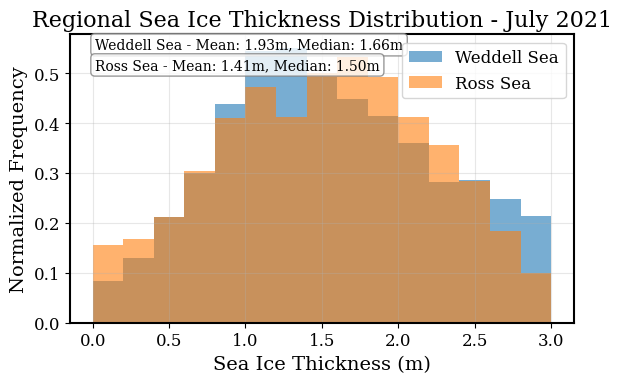

Regional analysis complete


In [24]:
# Compare thickness distributions between regions for winter (July)
thickness_bins = np.arange(0, 3.1, 0.2)
jul_idx = 6  # July

# Extract thickness values for each region
jul_weddell_values = weddell_sit.isel(time=jul_idx).values.flatten()
jul_weddell_values = jul_weddell_values[~np.isnan(jul_weddell_values)]

jul_ross_values = ross_sit.isel(time=jul_idx).values.flatten()
jul_ross_values = jul_ross_values[~np.isnan(jul_ross_values)]

# Create histogram plot
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histograms
ax.hist(jul_weddell_values, bins=thickness_bins, alpha=0.6, density=True, 
        color='#1f77b4', label='Weddell Sea')
ax.hist(jul_ross_values, bins=thickness_bins, alpha=0.6, density=True, 
        color='#ff7f0e', label='Ross Sea')

# Add labels and title
ax.set_xlabel(f"Sea Ice Thickness ({ds[sit_var].attrs.get('units', 'm')})")
ax.set_ylabel("Normalized Frequency")
ax.set_title(f"Regional Sea Ice Thickness Distribution - July 2021")
ax.grid(True, alpha=0.3)
ax.legend()

# Add statistics annotation
weddell_stats = f"Weddell Sea - Mean: {np.mean(jul_weddell_values):.2f}m, Median: {np.median(jul_weddell_values):.2f}m"
ross_stats = f"Ross Sea - Mean: {np.mean(jul_ross_values):.2f}m, Median: {np.median(jul_ross_values):.2f}m"
ax.annotate(weddell_stats, xy=(0.05, 0.95), xycoords='axes fraction', 
            fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="w", ec="gray", alpha=0.8))
ax.annotate(ross_stats, xy=(0.05, 0.88), xycoords='axes fraction', 
            fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="w", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()

print("Regional analysis complete")

### Austral Winter Period (May-October) Analysis in the Ross and Weddell Seas

We further narrow our focus to examine sea-ice conditions during the austral winter period (May-October) in the Weddell and Ross seas. This period represents the primary sea-ice growth season, with important implications for ocean-atmosphere heat exchange, deep water formation, and ecosystem functioning.

In [25]:
## Austral Winter Analysis for Ross and Weddell Seas

# Define winter months (May-October)
winter_months = range(4, 10)  # 0-indexed, so 4=May, 9=October
winter_month_names = ['May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']

# Extract winter data for both regions
weddell_winter = weddell_sit.isel(time=winter_months)
ross_winter = ross_sit.isel(time=winter_months)

# Calculate winter statistics
weddell_winter_mean = weddell_winter.mean(dim='time')
ross_winter_mean = ross_winter.mean(dim='time')

weddell_winter_monthly_means = np.array([weddell_winter.isel(time=i).mean().values for i in range(len(winter_months))])
ross_winter_monthly_means = np.array([ross_winter.isel(time=i).mean().values for i in range(len(winter_months))])

print("\nWinter (May-October) Statistics:")
print(f"Weddell Sea - Winter mean: {weddell_winter_mean.mean().values:.2f} m")
print(f"Ross Sea - Winter mean: {ross_winter_mean.mean().values:.2f} m")
print(f"Weddell/Ross thickness ratio: {weddell_winter_mean.mean().values/ross_winter_mean.mean().values:.2f}")


Winter (May-October) Statistics:
Weddell Sea - Winter mean: 1.51 m
Ross Sea - Winter mean: 1.13 m
Weddell/Ross thickness ratio: 1.33


#### Winter Sea Ice Thickness Maps

This visualisation presents the mean winter sea-ice thickness spatial patterns in the Weddell and Ross seas. The maps illustrate the accumulated effect of winter growth processes and reveal characteristic regional thickness patterns that develop during the extended freezing period. These patterns reflect the influence of local oceanographic conditions and atmospheric forcing.

C:\Users\xliu38\AppData\Local\Temp\ipykernel_8736\2759102914.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


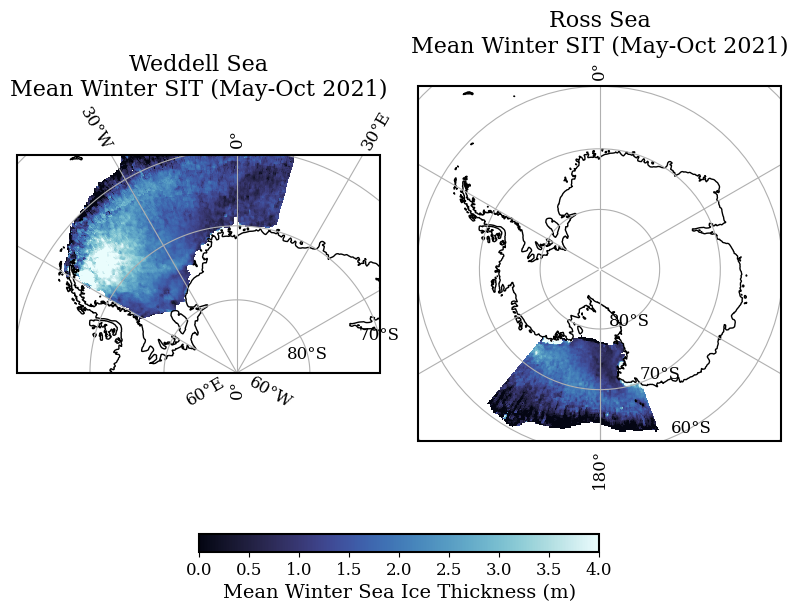

In [26]:
# Create winter average thickness maps for both seas
fig = plt.figure(figsize=(8, 6))

# Common parameters
vmin, vmax = 0, 4
cmap = cmo.ice
cbar_label = f"Mean Winter Sea Ice Thickness ({ds[sit_var].attrs.get('units', 'm')})"

# 1. Weddell Sea
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())
ax1.set_extent([-80, 40, -90, -60], crs=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines(draw_labels=True)

mesh1 = ax1.pcolormesh(weddell_winter_mean.lon, weddell_winter_mean.lat, weddell_winter_mean, 
                      transform=ccrs.PlateCarree(),
                      cmap=cmap, vmin=vmin, vmax=vmax)
ax1.set_title(f"Weddell Sea\nMean Winter SIT (May-Oct 2021)")

# 2. Ross Sea
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.SouthPolarStereo())
ax2.set_extent([160, -140, -90, -60], crs=ccrs.PlateCarree())
ax2.coastlines()
ax2.gridlines(draw_labels=True)

mesh2 = ax2.pcolormesh(ross_winter_mean.lon, ross_winter_mean.lat, ross_winter_mean, 
                      transform=ccrs.PlateCarree(),
                      cmap=cmap, vmin=vmin, vmax=vmax)
ax2.set_title(f"Ross Sea\nMean Winter SIT (May-Oct 2021)")

# Add common colorbar
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.03])
cbar = fig.colorbar(mesh1, cax=cbar_ax, orientation='horizontal')
cbar.set_label(cbar_label)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

#### Winter Temporal Evolution

Here we analyse the monthly progression of mean sea-ice thickness throughout the austral winter in both regions. The time series reveals the differing rates of ice growth and regional responses to seasonal forcing. We identify key periods of accelerated growth and stabilisation, providing insights into the thermodynamic and dynamic processes controlling regional ice development.

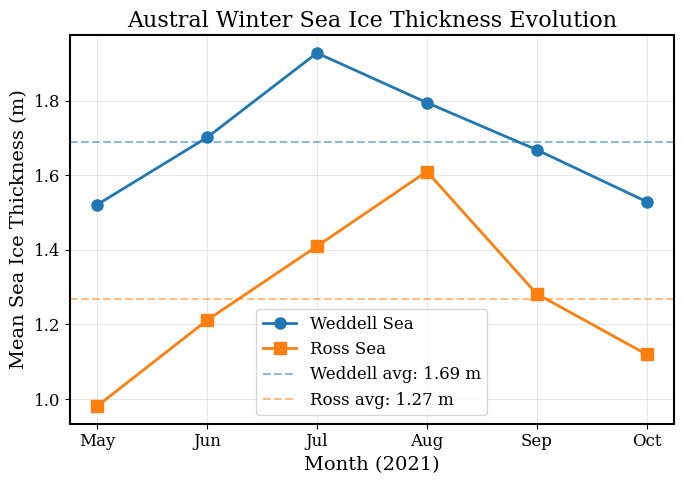

In [29]:
# Plot winter month progression
fig, ax = plt.subplots(figsize=(7, 5))

# Plot monthly mean thickness for each region during winter
ax.plot(range(len(winter_months)), weddell_winter_monthly_means, 'o-', 
        linewidth=2, markersize=8, color='#1f77b4', label='Weddell Sea')
ax.plot(range(len(winter_months)), ross_winter_monthly_means, 's-', 
        linewidth=2, markersize=8, color='#ff7f0e', label='Ross Sea')

# Add labels and formatting
ax.set_xticks(range(len(winter_months)))
ax.set_xticklabels(winter_month_names)
ax.set_ylabel(f"Mean Sea Ice Thickness (m)")
ax.set_xlabel("Month (2021)")
ax.set_title("Austral Winter Sea Ice Thickness Evolution")
ax.grid(True, alpha=0.3)
ax.legend(loc='best')

# Add winter average as horizontal lines
weddell_avg = np.mean(weddell_winter_monthly_means)
ross_avg = np.mean(ross_winter_monthly_means)
ax.axhline(y=weddell_avg, color='#1f77b4', linestyle='--', alpha=0.5, 
           label=f'Weddell avg: {weddell_avg:.2f} m')
ax.axhline(y=ross_avg, color='#ff7f0e', linestyle='--', alpha=0.5, 
           label=f'Ross avg: {ross_avg:.2f} m')

# Update legend with averages
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2] + handles[2:], labels[:2] + labels[2:], loc='best')

plt.tight_layout()
plt.show()

#### Regional Winter Thickness Distribution Comparison

This section presents a statistical comparison of winter sea-ice thickness distributions between the Weddell and Ross seas. By analysing the complete winter period, we capture the full range of thickness variability and enable robust comparison of regional characteristics. The analysis quantifies differences in mean thickness, variability, and distribution shape between these important Antarctic regions.

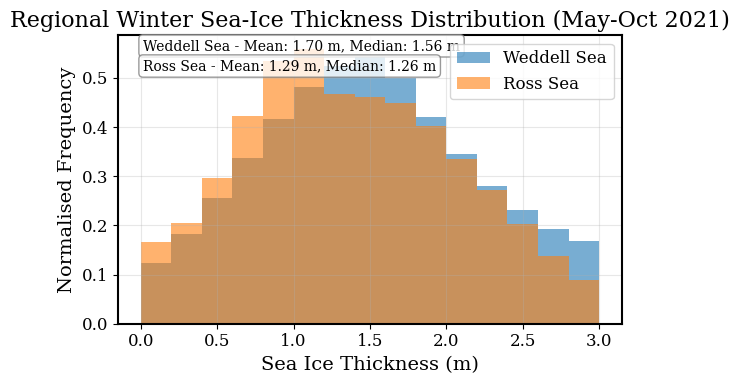

In [31]:
# Compare winter thickness distributions between regions
thickness_bins = np.arange(0, 3.1, 0.2)

# Get all winter values for each region
weddell_winter_values = weddell_winter.values.flatten()
weddell_winter_values = weddell_winter_values[~np.isnan(weddell_winter_values)]

ross_winter_values = ross_winter.values.flatten()
ross_winter_values = ross_winter_values[~np.isnan(ross_winter_values)]

# Create histogram plot
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histograms
ax.hist(weddell_winter_values, bins=thickness_bins, alpha=0.6, density=True, 
        color='#1f77b4', label='Weddell Sea')
ax.hist(ross_winter_values, bins=thickness_bins, alpha=0.6, density=True, 
        color='#ff7f0e', label='Ross Sea')

# Add labels and title
ax.set_xlabel(f"Sea Ice Thickness (m)")
ax.set_ylabel("Normalised Frequency")
ax.set_title(f"Regional Winter Sea-Ice Thickness Distribution (May-Oct 2021)")
ax.grid(True, alpha=0.3)
ax.legend()

# Add statistics annotation
weddell_stats = f"Weddell Sea - Mean: {np.mean(weddell_winter_values):.2f} m, Median: {np.median(weddell_winter_values):.2f} m"
ross_stats = f"Ross Sea - Mean: {np.mean(ross_winter_values):.2f} m, Median: {np.median(ross_winter_values):.2f} m"
ax.annotate(weddell_stats, xy=(0.05, 0.95), xycoords='axes fraction', 
            fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="w", ec="gray", alpha=0.8))
ax.annotate(ross_stats, xy=(0.05, 0.88), xycoords='axes fraction', 
            fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="w", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()